# ARIMA Modeling

### Learning Objectives
This is meant as a quick checkout to compare the results of our complex LSTM NLP model with that of a simplistic SARIMAX model
We will:
- Conduct and interpret an augmented Dickey-Fuller test for stationarity.
- Construct integrated autoregressive moving average (ARIMA) models for rates .
- Fit and tune a SARIMAX model.

In [ ]:
# !pip install scipy statsmodels --upgrade

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

In [5]:
# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [6]:
# Read in data.
data = pd.read_parquet('../data/bonds.parquet')
short_rates = pd.read_parquet('../data/three_month_rates.parquet')
cpi = pd.read_parquet('../data/cpi.parquet')

In [7]:
cpi.head()
data = data.drop(data.index[:2])

In [8]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col], label=col)  # Add label parameter to your plot
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Create the legend and place it in the upper right corner.
    plt.legend(loc='upper right')
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18)

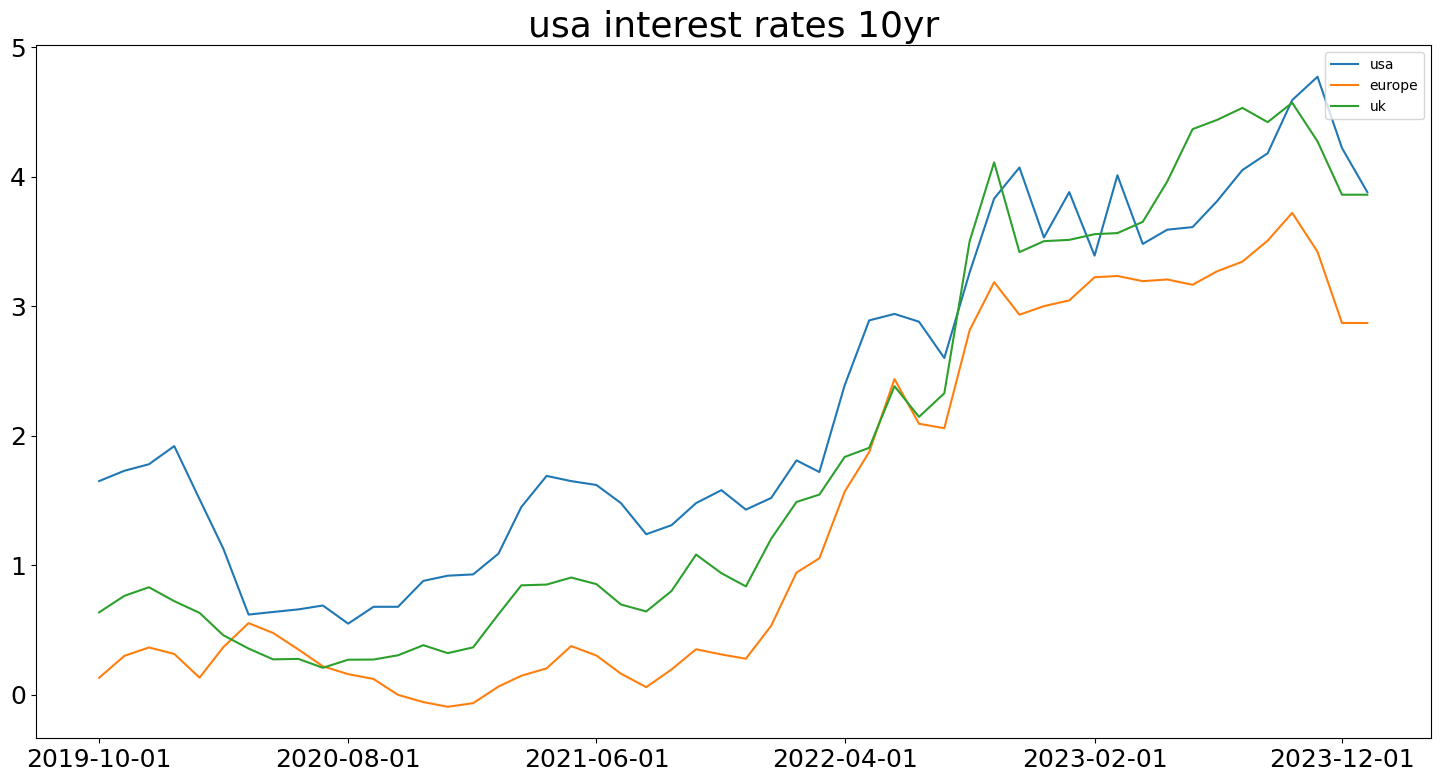

In [9]:
# Generate a time plot of our bus ridership data.
plot_series(data, ['usa', 'europe', 'uk'], title = 'usa interest rates 10yr', steps=10)

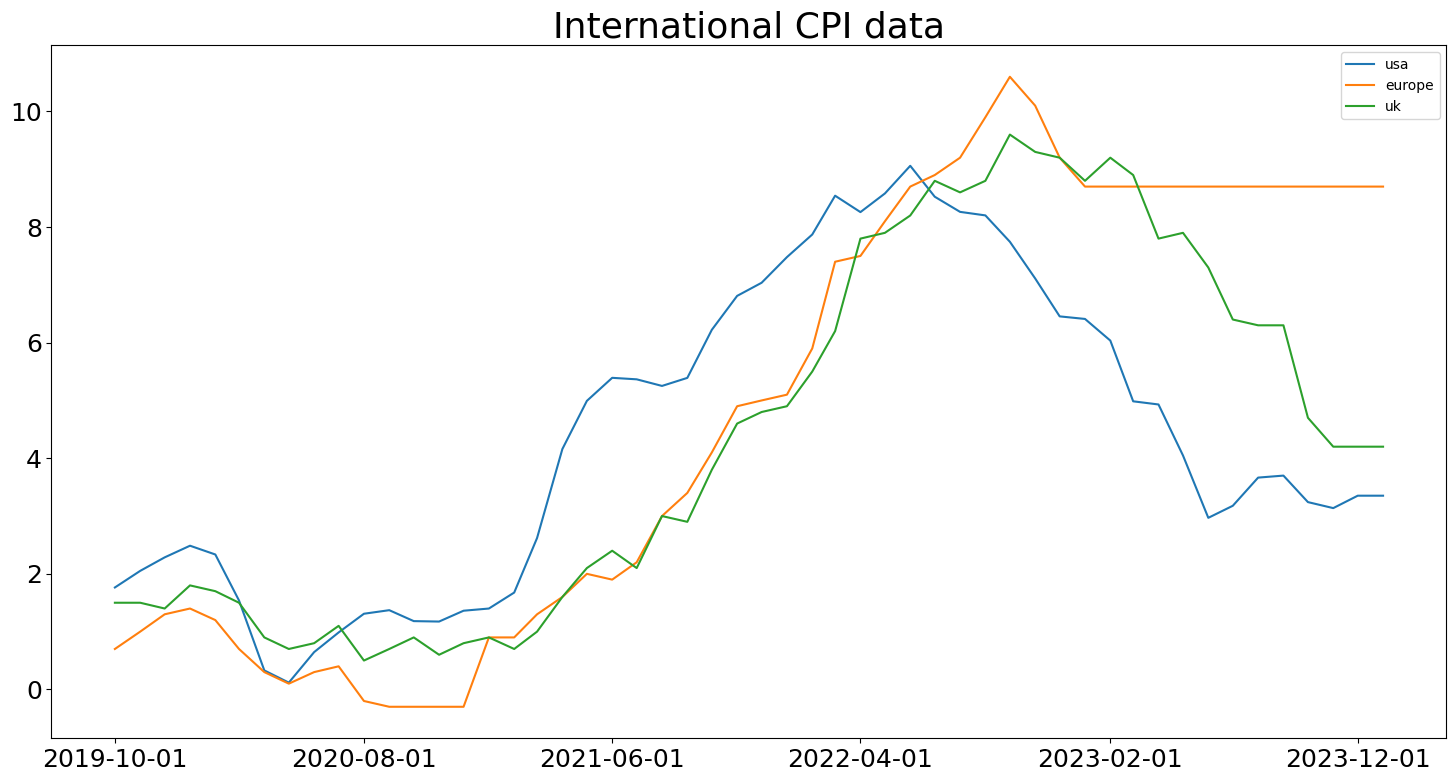

In [10]:
plot_series(cpi, ['usa', 'europe', 'uk'], title = 'International CPI data', steps=10)

<details><summary>Check: How would you describe this data?</summary>
    
- **Trend**: The mean (straight-line trend) is increasing (but levels off around 1980).
- **Seasonality**: There appears to be some seasonality each year; this is especially apparent in the 1976-1979 window.
- **Cyclic**: Maybe, but not sure.
- **Autocorrelation**: The data are correlated with one another.
</details>

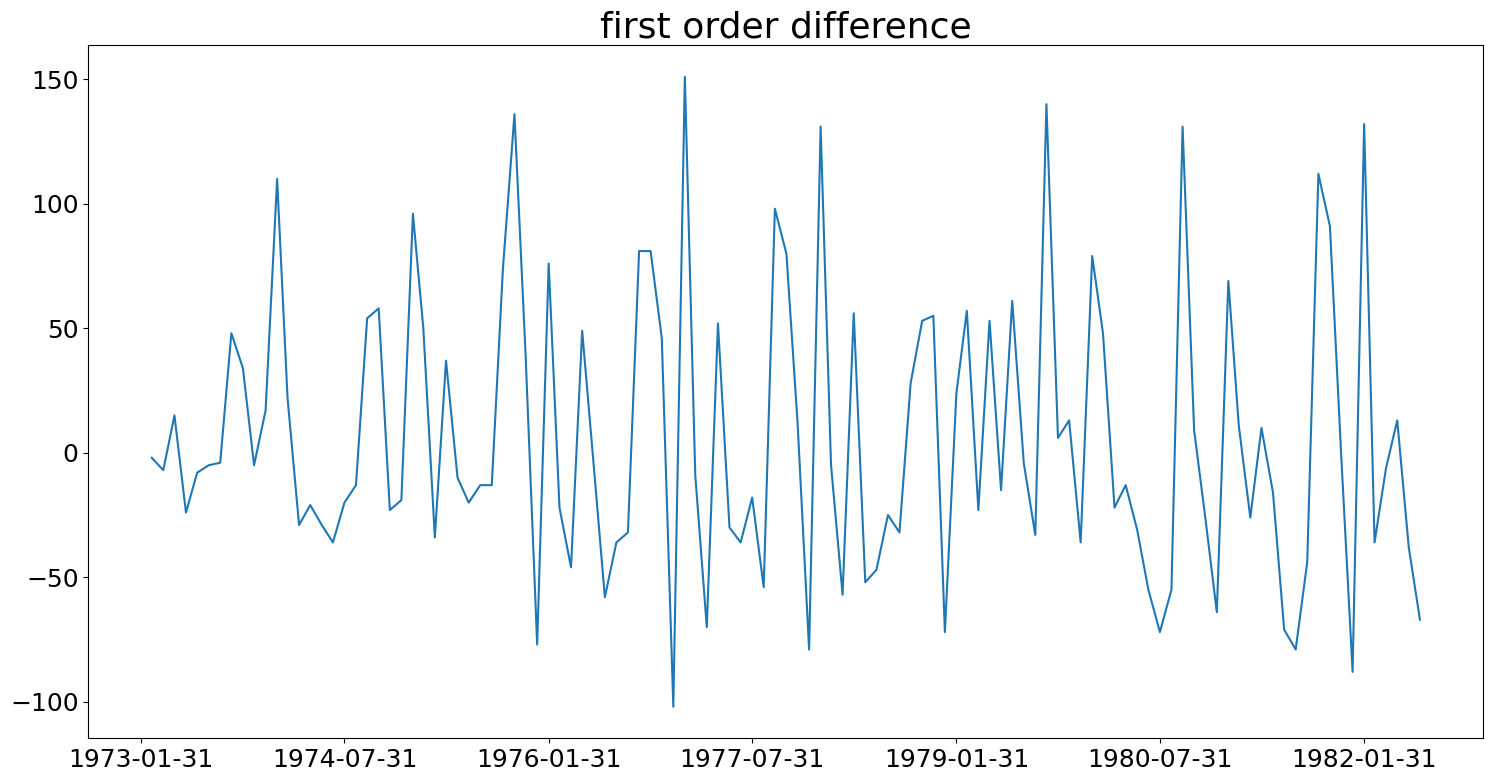

In [17]:
# Bus ridership data.
plot_series(portland, ['diff'], title='first order difference', steps = 18)

#### Checking for Stationarity: the Augmented Dickey-Fuller Test

In [12]:
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

# Run ADF test on original (non-differenced!) data.
adfuller(data['usa'])

(-0.4121245787224432,
 0.908054639726112,
 0,
 53,
 {'1%': -3.560242358792829,
  '5%': -2.9178502070837,
  '10%': -2.5967964150943397},
 22.995958368716217)

In [14]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [16]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(data['usa'].diff().dropna()))

Test Statistic   -4.585934
p-value           0.000137
dtype: float64

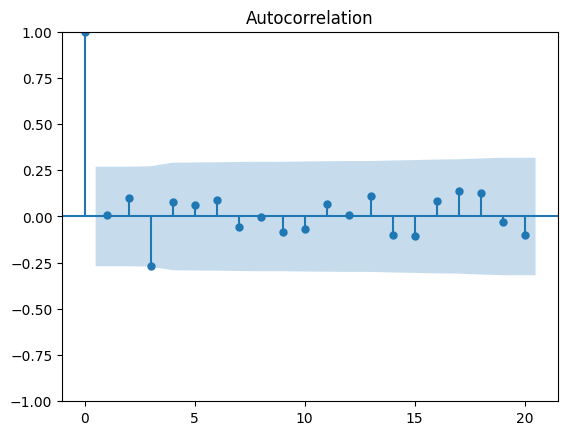

In [17]:
# Generate plot.
plot_acf(data['usa'].diff().dropna(), lags=20);

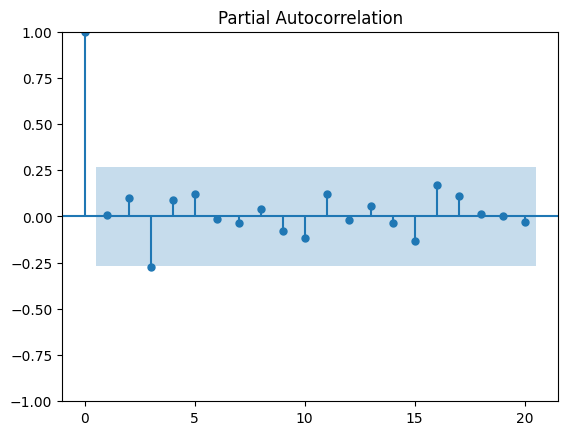

In [18]:
# Generate plot.
plot_pacf(data['usa'].diff().dropna(), lags=20);

<details><summary>How would you interpret the partial autocorrelation plot here?</summary>

### Interpret the partial autocorrelation plot.
1. The partial autocorrelation plot above shows that observations are highly correlated with one another. 
2. **However, the partial autocorrelation plot checks for the correlation between observations, conditioning on all lower-lag autocorrelations.** (That is, the partial autocorrelation between $Y_t$ and $Y_{t-2}$ is the correlation between $Y_t$ and $Y_{t-2}$ that has already taken into account the autocorrelation between $Y_t$ and $Y_{t-1}$.)
3. The blue band indicates the 95% confidence interval for these correlations.
    - Observations inside the blue band mean that there is no significant correlations between $Y_t$ and $Y_{t-k}$ for lag $k$, **accounting for all lower-order lags**.
    - Observations outside the blue band mean that there **is** a significant correlation between $Y_t$ and $Y_{t-k}$ for lag $k$, **accounting for all lower-order lags**.
</details>

#### Determining a Value of $p$ based on the PACF.

If the PACF (partial autocorrelation function) has a sharp cut-off and the lag-1 PACF value is positive, choose $p$ to be the lag in the PACF before the cut-off.
- Note: $p=1$ is the most common.

If the PACF does not have a sharp cut-off or the lag-1 ACF value is not positive, then let $p=0$.

<details><summary>Based on the PACF, what value of $p$ would you select?</summary>

- The PACF has a sharp cut-off between lag 0 and lag 1.
- The first lag in the PACF is negative.
- Thus, we should set $p=0$.
</details>

In [13]:
# Create train-test split.
X_train, X_test, y_train, y_test = train_test_split(cpi,
                                                    data['usa'],
                                                    test_size = 0.3,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

### Fit an ARIMA model.


In [22]:
# Import ARIMA model.
from statsmodels.tsa.arima.model import ARIMA

In [23]:
# Instantiate model.

# Remember that, in statsmodels, we pass our data 
# in when we instantiate the model!
model = ARIMA(endog=y_train.astype(float).dropna(),order=(3,1,3))

# In the present version of statsmodels, only
# certain values of d are supported.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [24]:
# Fit model.
arima_1_1_1 = model.fit()

c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
y_test.head()

2022-10-01    3.83
2022-11-01    4.07
2022-12-01    3.53
2023-01-01    3.88
2023-02-01    3.39
Name: usa, dtype: float64

In [29]:
# Generate predictions.
preds = arima_1_1_1.predict(start = datetime(2022, 10, 1), end = datetime(2024, 1, 1))

<details><summary>What do these predicted values represent?</summary>

- These predicted values represent $Y''_t$, which is the second-order differenced bus ridership data.
- The first observation represents the "change of the change" in bus ridership in January 1973.
- The second observation represents the "change of the change" in bus ridership in February 1973.
- And so on.
</details>

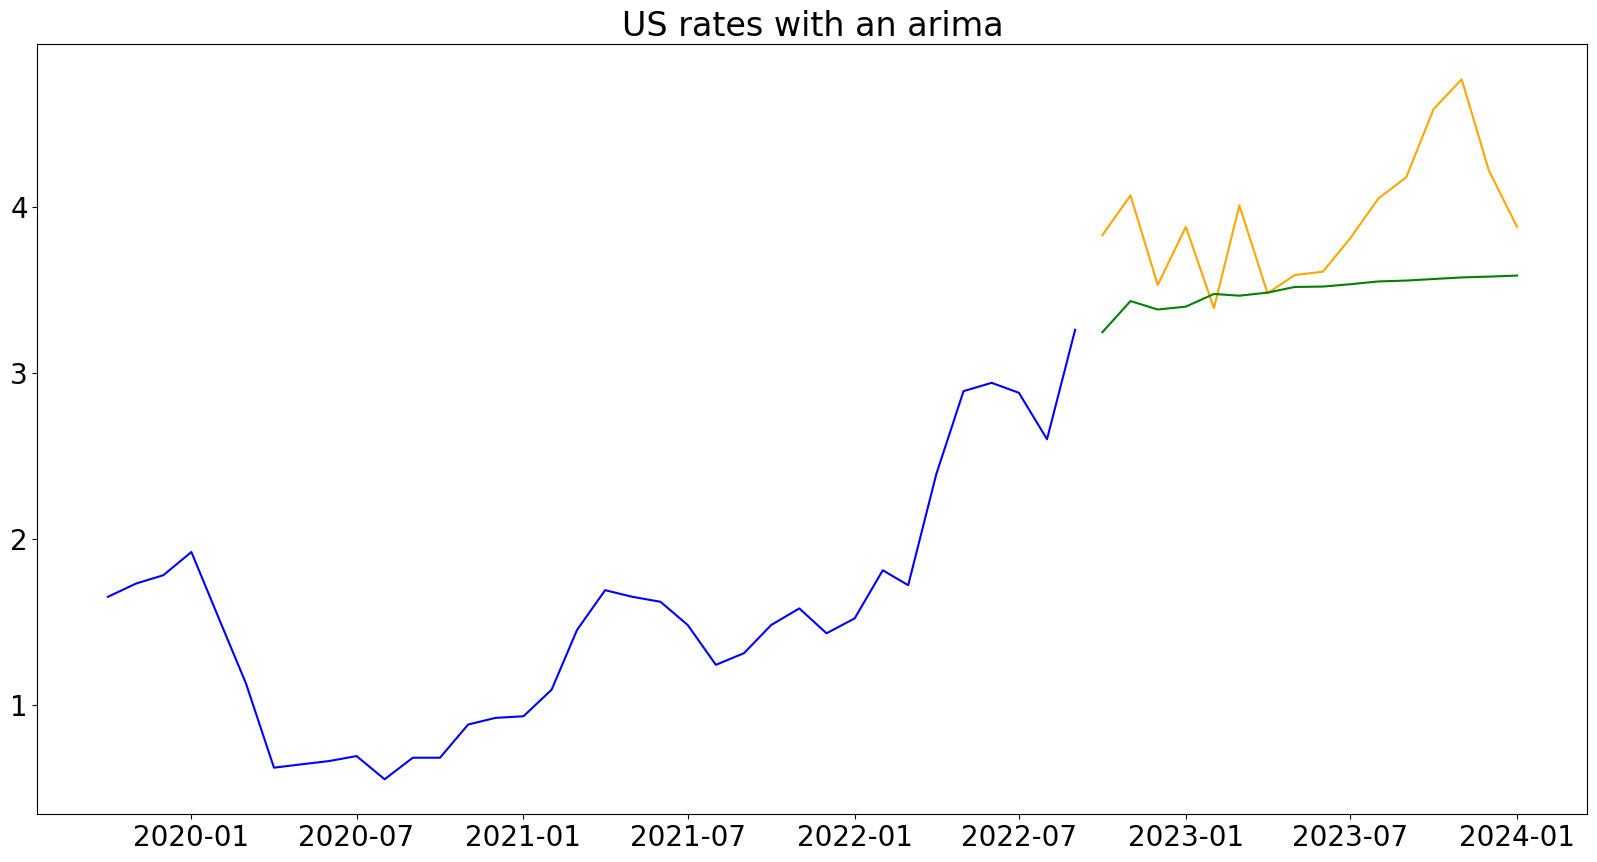

In [30]:
# Plot data.
# Set figure size.
plt.figure(figsize=(20,10))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')
# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')
# Set label.
plt.title(label = 'US rates with an arima', fontsize=24)
# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [73]:
# Evaluate these predictions using MSE.
from  sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test, preds))

2.099425084816092


In [74]:
arima_0_1_0.aic

1.969347519516357

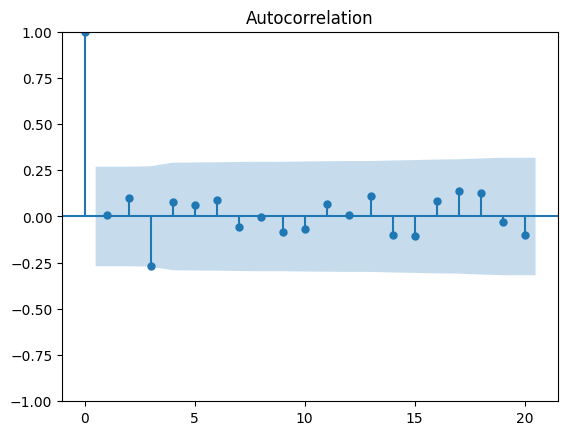

In [75]:
# Generate ACF plot.
plot_acf(data['usa'].diff().dropna(), lags = 20);


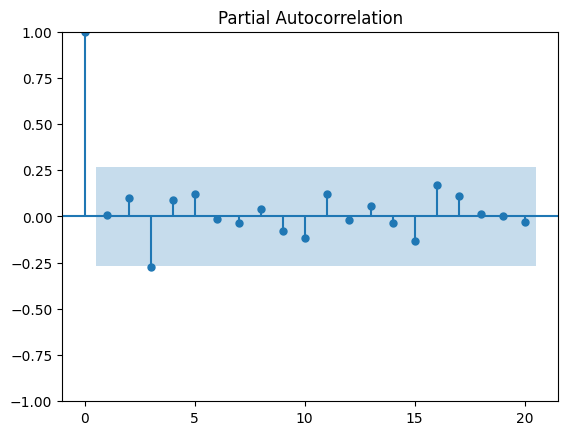

In [76]:
# Generate PACF plot.
plot_pacf(data['usa'].diff().dropna(), lags = 20);


In [48]:
# Instantiate model.

# Remember that, in statsmodels, we pass our data 
# in when we instantiate the model!
model = ARIMA(endog=y_train.astype(float).dropna(), order = (3, 1, 3))


# Fit model.
arima_0_2_1 = model.fit()


# Generate predictions.
preds = arima_0_2_1.predict(start = datetime(1979, 8, 31), end = datetime(1982, 6, 30))

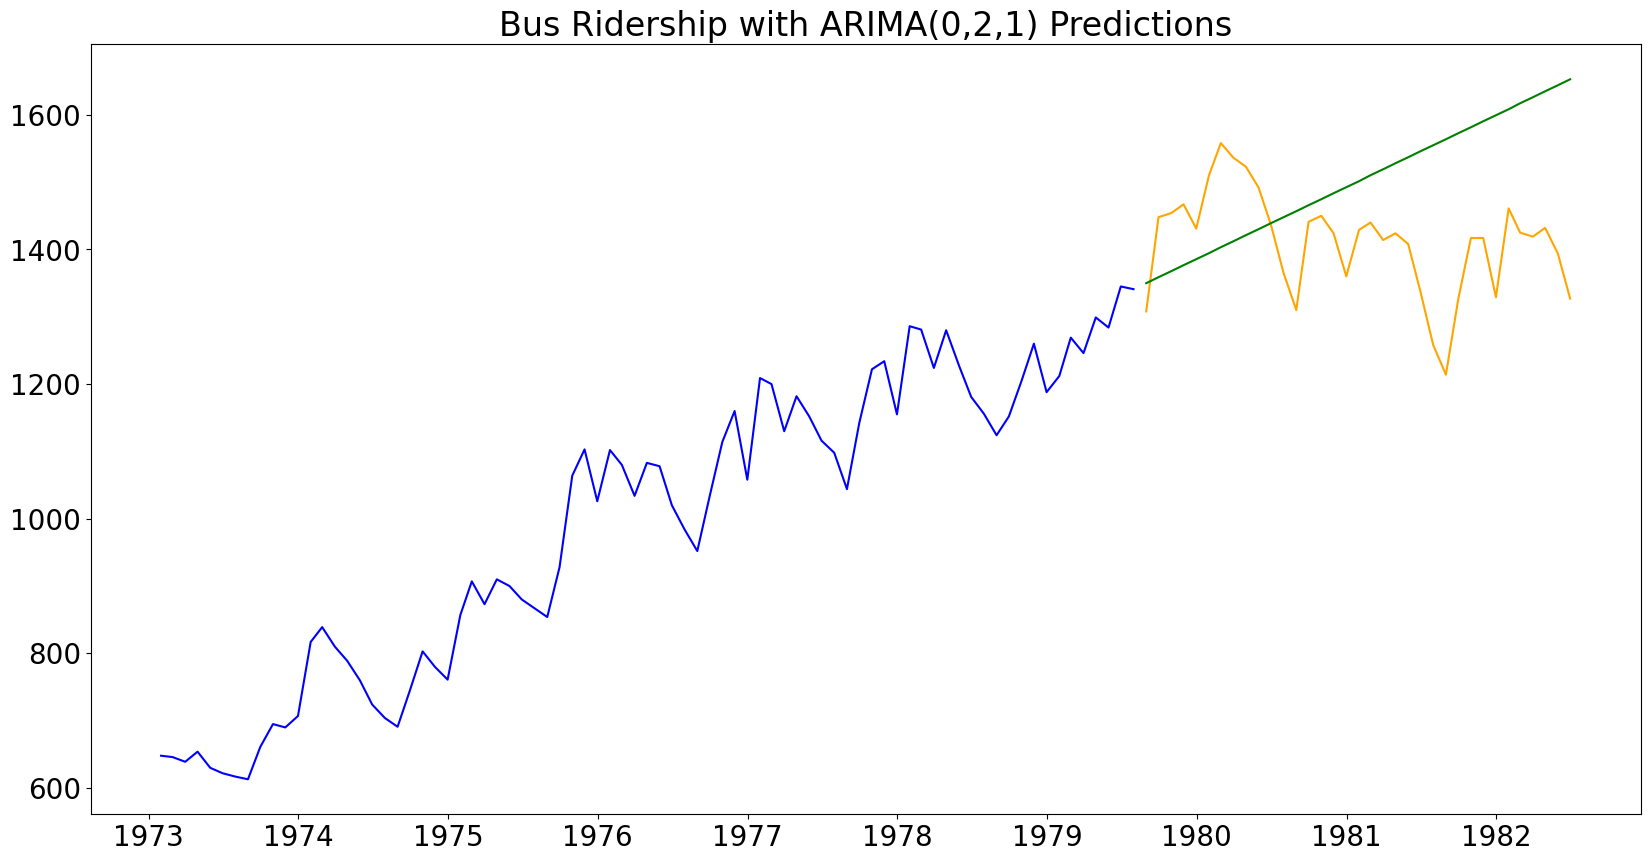

In [49]:
# Plot data.

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

# Set label.
plt.title(label = 'Bus Ridership with ARIMA(0,2,1) Predictions', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## Seasonal Model

We can think of seasonality as a repeating pattern (like a cycle) that occurs over time.

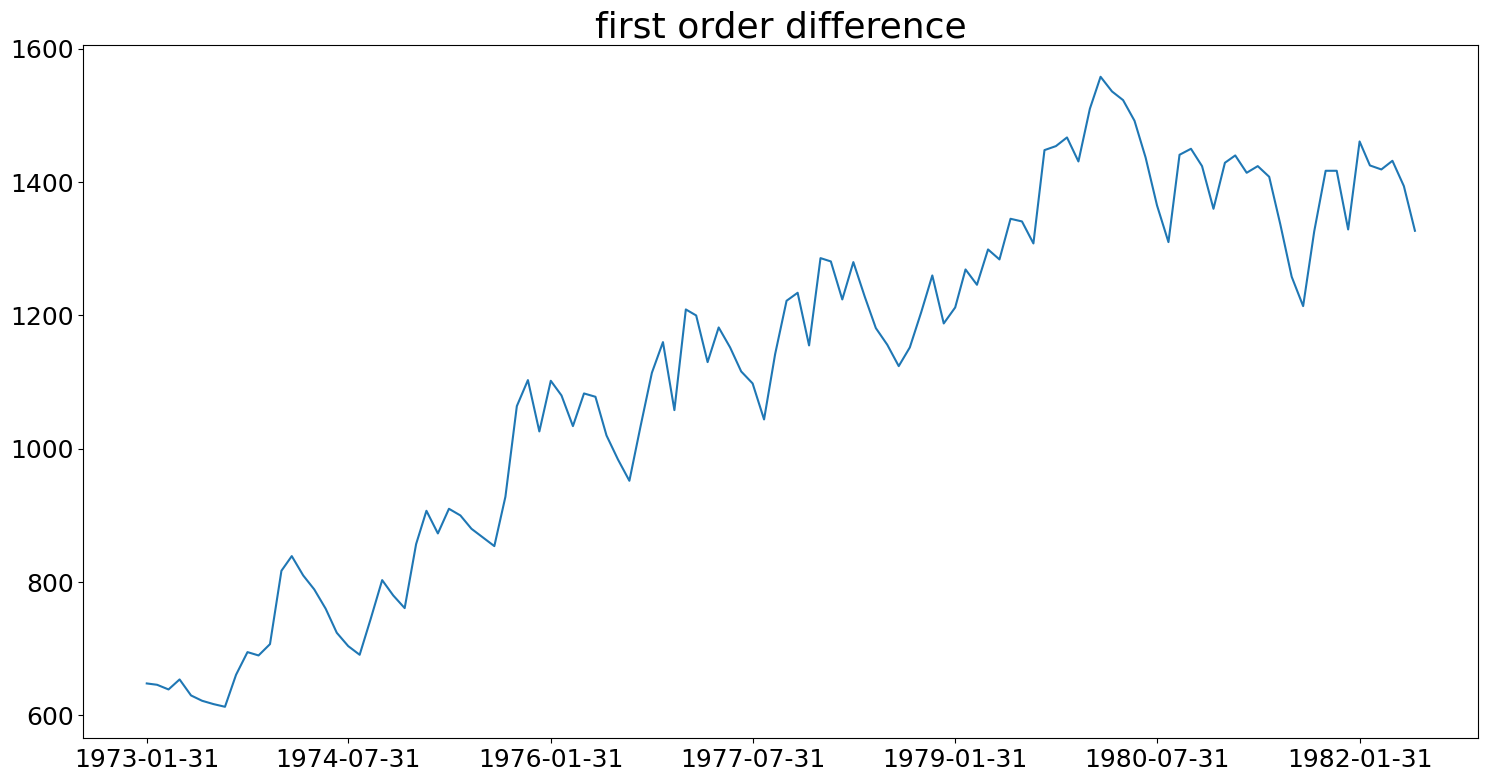

In [52]:
# Plot data.
plot_series(portland, ['bus_ridership'], title='first order difference', steps = 18)


<details><summary>By looking at this data, is there is strong evidence of seasonality? If so, what evidence supports seasonality?</summary>

- Yes! There are repeated spikes that seem to occur every year or so.
- If we look back on our differenced ACF plot, we note a cyclical pattern as well.
</details>

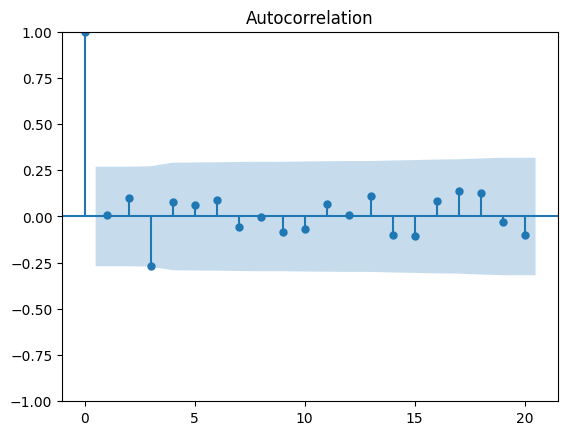

In [45]:
# Generate ACF plot.
plot_acf(data['usa'].diff().dropna(), lags = 20);

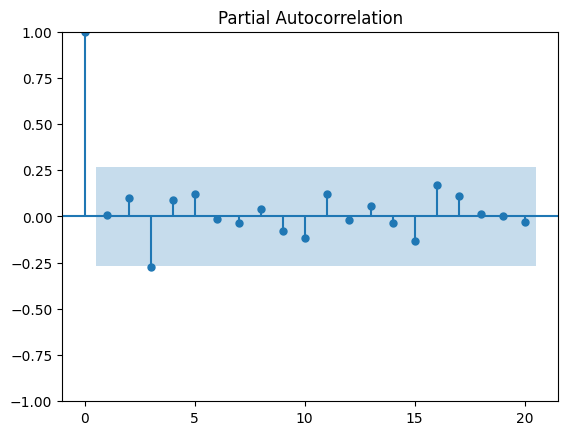

In [46]:
# Generate PACF plot.
plot_pacf(data['usa'].diff().dropna(), lags = 20);

In [32]:
# Import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13.365149046908211


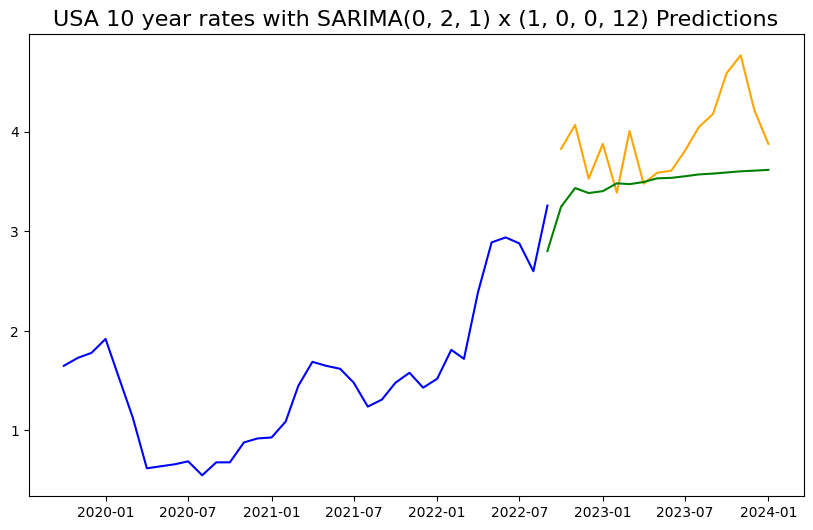

In [33]:
# Fit a SARIMA(0, 2, 1) x (1, 0, 0, 12) model.
sarima = SARIMAX(endog=y_train.astype(float).dropna(),
                order = (3, 1, 3), seasonal_order=(1, 0, 0, 12)) #1 repeat seasonality repeated every 12 months

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start = datetime(2022, 9, 1), end = datetime(2024, 1, 1))

# Evaluate predictions.
print(model.aic)

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'USA 10 year rates with SARIMA(0, 2, 1) x (1, 0, 0, 12) Predictions', fontsize=16)
plt.show();

In [34]:
# Convert training/testing sets to a DataFrame.
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
# Add column for lagged values of precipitation.
X_train['us_cpi_lag_1'] = X_train['usa'].shift()
X_test['us_cpi_lag_1'] = X_test['usa'].shift()
# Check out top of the test dataframe.
X_train.tail()
#X_test.head()

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea,us_cpi_lag_1
2022-05-01,8.581512,118.422633,8.1,7.9,6.144781,11.731213,6.965174,2.942478,3.880709,5.399314,8.258629
2022-06-01,9.059758,119.543604,8.7,8.2,6.144781,11.886870,6.162695,3.384971,3.880709,6.046056,8.581512
2022-07-01,8.524815,119.543604,8.9,8.8,7.268170,10.069403,5.781759,3.433476,3.880709,6.336789,9.059758
2022-08-01,8.262693,119.783813,9.2,8.6,7.268170,8.727291,5.853659,3.452120,3.880709,5.712895,8.524815
2022-09-01,8.201670,119.863882,9.9,8.8,7.268170,7.168825,6.488240,3.252485,3.880709,5.583018,8.262693


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12.00578173720225


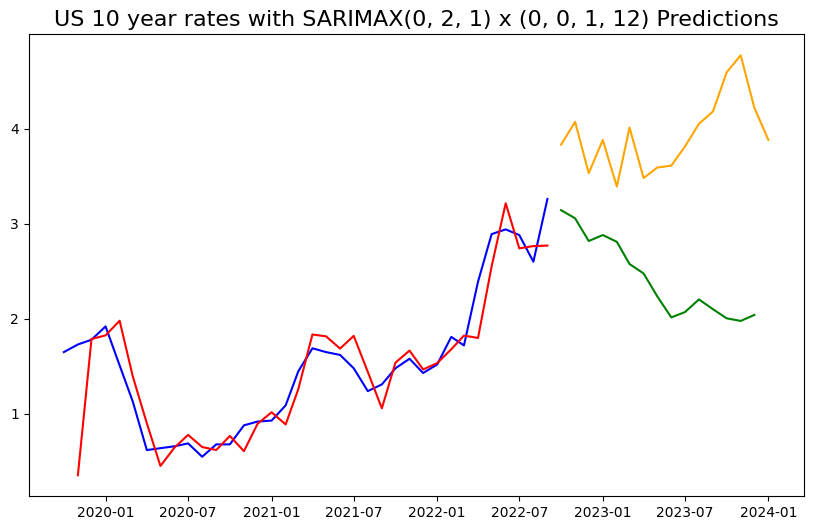

In [39]:
# Fit a SARIMA(0, 2, 1) x (0, 0, 1, 12) model.
sarima = SARIMAX(endog=y_train[1:].astype(float).dropna(),
                order = (3, 1, 2), seasonal_order=(1, 0, 0, 12),
                exog = X_train['us_cpi_lag_1'].dropna())


# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
overlap = model.predict(start = datetime(2019, 11, 1), end = datetime(2022, 9, 1),
                     exog = X_train['us_cpi_lag_1'].dropna())
preds = model.predict(start = datetime(2022, 10, 1), end = datetime(2023, 12, 1),
                     exog = X_test['us_cpi_lag_1'].dropna())

# Evaluate predictions.
print(model.aic)

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.plot(overlap, color = 'red')
plt.title(label = 'US 10 year rates with SARIMAX(0, 2, 1) x (0, 0, 1, 12) Predictions', fontsize=16)
plt.show();

### Manual GridSearch


In [49]:
y_train.head()

2019-10-01    1.65
2019-11-01    1.73
2019-12-01    1.78
2020-01-01    1.92
2020-02-01    1.51
Name: usa, dtype: float64

In [52]:
X_test.head()

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea,us_cpi_lag_1
2022-10-01,7.745427,120.584507,10.6,9.6,7.831822,6.470372,6.084868,2.996002,3.880709,5.670053,NaN
2022-11-01,7.110323,121.225062,10.1,9.3,7.831822,5.900729,5.409706,2.960212,3.880709,5.035140,7.745427
2022-12-01,6.454401,120.744645,9.2,9.2,7.831822,5.785093,5.502392,2.840312,3.880709,5.036524,7.110323
2023-01-01,6.410147,121.305131,8.7,8.8,7.021792,5.774497,6.155076,3.282533,2.318157,5.167638,6.454401
2023-02-01,6.035613,122.025756,8.7,9.2,7.021792,5.596405,6.160000,3.371806,2.318157,4.824311,6.410147


In [41]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in range(0,13,4):
                try:
                    print(f'Attempting to fit SARIMAX(0,2,1)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = y_train[1:],
                                     order = (3, 1, 2),              # (p, d, q)
                                     seasonal_order = (P, D, Q, S),  # (P, D, Q, S)
                                     exog = X_train['us_cpi_lag_1'].dropna()) 
 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=start,
                                          end=stop,
                                          exog=X_test['us_cpi_lag_1'].dropna())

                    # Evaluate predictions.
                    print(f'The MSE for (0, 1, 1)x({P},{D},{Q},{S}) is: {mean_squared_error(y_test[1:len(y_test)-1], preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(y_test[1:len(y_test)-1], preds):
                        best_mse = mean_squared_error(y_test[1:len(y_test)-1], preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 2, 1)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(0,2,1)x(0,0,0,0)
Attempting to fit SARIMAX(0,2,1)x(0,0,0,4)
Attempting to fit SARIMAX(0,2,1)x(0,0,0,8)
Attempting to fit SARIMAX(0,2,1)x(0,0,0,12)
Attempting to fit SARIMAX(0,2,1)x(0,1,0,0)
Attempting to fit SARIMAX(0,2,1)x(0,1,0,4)
Attempting to fit SARIMAX(0,2,1)x(0,1,0,8)
Attempting to fit SARIMAX(0,2,1)x(0,1,0,12)
Attempting to fit SARIMAX(0,2,1)x(0,2,0,0)
Attempting to fit SARIMAX(0,2,1)x(0,2,0,4)
Attempting to fit SARIMAX(0,2,1)x(0,2,0,8)
Attempting to fit SARIMAX(0,2,1)x(0,2,0,12)
Attempting to fit SARIMAX(0,2,1)x(0,0,1,0)
Attempting to fit SARIMAX(0,2,1)x(0,0,1,4)
Attempting to fit SARIMAX(0,2,1)x(0,0,1,8)
Attempting to fit SARIMAX(0,2,1)x(0,0,1,12)
Attempting to fit SARIMAX(0,2,1)x(0,1,1,0)
Attempting to fit SARIMAX(0,2,1)x(0,1,1,4)
Attempting to fit SARIMAX(0,2,1)x(0,1,1,8)
Attempting to fit SARIMAX(0,2,1)x(0,1,1,12)
Attempting to fit SARIMAX(0,2,1)x(0,2,1,0)
Attempting to fit SARIMAX(0,2,1)x(0,2,1,4)
Attempting to fit SARIMAX(0,2,1)x(0,2,1,8)
Attemp

c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


782.2085664888484


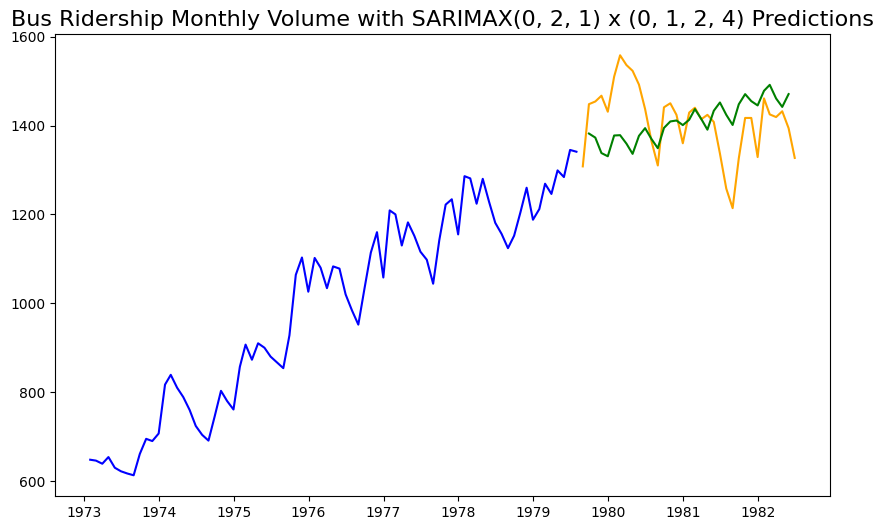

In [64]:
# Fit a SARIMA(0, 2, 1) x (0, 1, 2, 4) model.
sarima = SARIMAX(endog = y_train[1:],
                                     order = (0, 2, 1),              # (p, d, q)
                                     seasonal_order = (0, 1, 2, 4),  # (P, D, Q, S)
                                     exog = X_train['precip_lag_1'].dropna()) 

# Fit SARIMA model.
model = sarima.fit()

print(model.aic)

# Generate predictions based on test set.
preds = model.predict(start = datetime(1979, 9, 30),
                     end = datetime(1982, 5, 31),
                     exog = X_test['precip_lag_1'].dropna())

# Evaluate predictions.

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Bus Ridership Monthly Volume with SARIMAX(0, 2, 1) x (0, 1, 2, 4) Predictions', fontsize=16)
plt.show();

## Takeaways

While we GridSearched over a range of values for the parameters in our SARIMAX model, our model here doesn't look *that* great. Why might that be?

- Looking at the original time plot of our data, when we split our data into the training and the testing sets, it appears that our testing data looks a bit different from our training data. (Obviously this will affect our model, since we only fit on our testing set!) This isn't something we often have much control over.
- There are many, many factors that affect the number of people who take the bus in Portland.
    - The number of bus passengers in the past.
    - Precipitation.
    - Temperature.
    - The population of Portland.
    - The price of cars. (e.g. if cars got cheaper around 1980, perhaps more people began taking cars instead of buses.)
    - Other alternative modes of transportation. (e.g. are there other forms of public transportation, like a train/subway that may affect the number of passengers?)
- **Forecasting time series is exceptionally difficult to do well!** We're using the past to predict the future, and there aren't guarantees that the future is necessarily going to be reflective of the past.